This project includes the following phases :
- Pre-processing & Data Augmentation
- Feature extraction
- Classification

The dataset used :    
- In the wild data provided
- Small dataset showcasing micro expressions in high quality : The objective of this addition is not merely having more data to train on, it's mainly to introduce real facial expressions showing micro expressions*1 that would not be visible in the first dataset.

1* *Micro expressions* : Facial expressions that last **less than 0.5s** and are therefore hard to detect. They can serve to distiguish between real emotion and fake or lab made expressions.


#Details :

### - Data Augmentation
- Color shift
  - YCbCr
  - YES
  --> compare separate training results between (YCbCr - YES - original (greyscale))

### - Feature extraction

0. Relevant features (Based on Business understanding) :
  - mouth ratio to face
  - nb of face curves
  - curves around eyes
  - curves around mouth
  - curves around nose
  - upper lip position relative to down lip : size of vertical distance between the two (relative to one lip length)
  - eyebrows pente relative to horizontal axis


1. Edge Detection (for curves)
  - Prewitt
  - Sobel is to consider

2. Filters (Optional part : for optimization)
  - Gabor filter
  - Local Binary Pattern (LBP)



### - Add microexpressions data & perform same pre-processing

The following choices of techniques adopted in this project (Edge detection filters, noise reducers...) are relative to the Business, in other words;
Emotions and facial expressions studies show that :     
- vertical wrinkles around the nose, a small upward tilt of the upper lip, small frowning ==> associated with disgust
- slight upwaard tilt on the sides of the mouth demonstrated with wrinkles + small wrinkles on the exterior sides of the eyes ==> indcator of genuine happiness.
- slight upward tilt on the sides of the mouth demonstrated with wrinkles + various degrees of frowning ==> associated with sadness.
- etc.

In [ ]:
!python --version

Python 3.10.12


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import seaborn as sns
from scipy import stats
import json
import ast
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix

from tqdm import tqdm
import itertools

import cv2
import os
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation


In [ ]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# 1
# This is to be executed when woring with colab with the corresponding url

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# 2
url = '/content/drive/MyDrive/2. Relevant Projects/1. Emotions Recognition/Dataset'  ## Colab Drive URL

#url = '/kaggle/input/ferdata'    ##Kaggle url

#Account 2
#url = '/content/drive/MyDrive/1. Emotions Recognition/Dataset'  ## Colab Drive URL


In [ ]:
url_2 = '/content/drive/MyDrive/2. Relevant Projects/1. Emotions Recognition'
train_RGB = url_2 + '/RGB'
train_YCBR = url_2 + '/YCBR'
#X_RGB, y_RGB, _ = load_data(train_RGB)


# Load Data

In [ ]:
train_dir = url +'/train'
test_dir = url + '/test'


#### Load Images as np array

In [ ]:
def load_data(dir_path, img_size=(48,48)):
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path +'/'+ path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path +'/'+ path + '/' + file)
                    X.append(img)
                    y.append(i)
                    i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [ ]:
# This is a function that loads data from a sub directory reltive to one emotion ( purpose : faster loading for testing certain functions later on and to save resources)

def load_data_One_Emotion(Sub_dir_path, img_size=(48,48)):
    X = []
    y = []
    i = 0
    labels = dict()

    for file in os.listdir(Sub_dir_path ):
        if not file.startswith('.'):
            img = cv2.imread(Sub_dir_path +'/' + file)
            X.append(img)
            y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {Sub_dir_path} directory.')
    return X, y, labels

In [ ]:
Sub_train_dir = url +'/train/disgust'   # Change emotion according to subdirectory, chosen disgust beacause it's the dataset with the least samples.
X_train_Emotion, y_train_Emotion, _ = load_data(Sub_train_dir)

436 images loaded from /content/drive/MyDrive/2. Relevant Projects/1. Emotions Recognition/Dataset/train/disgust directory.


In [ ]:
X_train, y_train, labels_tr = load_data(train_dir)

100%|██████████| 7/7 [09:35<00:00, 82.24s/it]

28779 images loaded from /content/drive/MyDrive/2. Relevant Projects/1. Emotions Recognition/Dataset/train directory.


In [ ]:
X_test, y_test,labels_ts = load_data(test_dir)

# Data Visualization

In [ ]:
labels_tr

{0: 'angry',
 4005: 'disgust',
 4441: 'fear',
 8548: 'happy',
 15763: 'neutral',
 20738: 'sad',
 25588: 'surprise'}

In [ ]:
# Function to count values of each emotion in the dataset ( separately for train & test data )

def count_values(labels_dict,X_data) :
    count = {}
    i = 0
    L=[]
    for key,value in labels_dict.items() :
        L.append(key)
    L.append(X_data.shape[0])
    for value in labels_dict.values() :
        count[value] = L[i+1]-L[i]
        i+=1
    return count

In [ ]:
Nb_train=count_values(labels_tr,X_train)
Nb_train

{'angry': 4005,
 'disgust': 436,
 'fear': 4107,
 'happy': 7215,
 'neutral': 4975,
 'sad': 4850,
 'surprise': 3191}

The data is unbalanced :
- disgust training data is 1/10 less than the other emotions' datasets.
- Happy has the maximum training data.

==> This should cause biased results in identifying those two emotions later in the test set.

In [ ]:
Nb_test=count_values(labels_ts,X_test)
Nb_test

In [ ]:
df_tr=pd.DataFrame.from_dict(Nb_train, orient='index')
df_tr = df_tr.rename(columns={0: "Count"})
#df_ts=pd.DataFrame.from_dict(Nb_test, orient='index')
#df_ts = df_ts.rename(columns={0: "Count"})

In [ ]:
df_tr

,Count
angry,4005
disgust,436
fear,4107
happy,7215
neutral,4975
sad,4850
surprise,3191


In [ ]:
df_ts

,Count
angry,958
disgust,111
fear,1044
happy,1774
neutral,1243
sad,1247
surprise,831


In [ ]:
df_ts.iloc[:, 0]

angry        958
disgust      111
fear        1044
happy       1774
neutral     1243
sad         1247
surprise     831
Name: Count, dtype: int64

28000


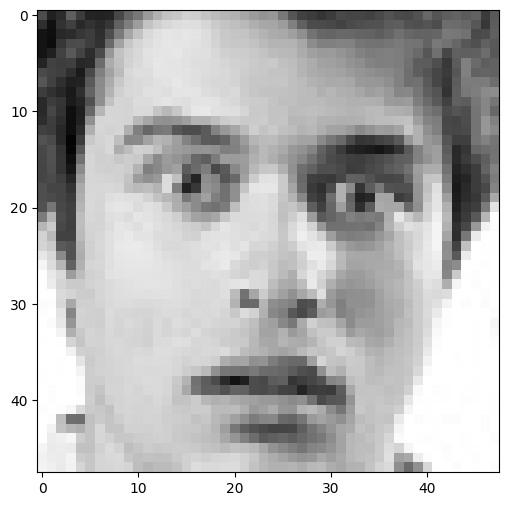

In [ ]:
# Visualiizing one specific picture by index
plt.figure(figsize=(15,6))
plt.imshow(X_train[28000])
print(y_train[28000])

In [ ]:
labels_tr

{0: 'angry',
 4005: 'disgust',
 4441: 'fear',
 8548: 'happy',
 15763: 'neutral',
 20738: 'sad',
 25588: 'surprise'}

In [ ]:
# This functions plots a set of pictures from the dataset with their label, it plots 50 pictures by default

def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Emotion: {}'.format(labels_dict[index]))
        plt.show()

In [ ]:
len(labels_tr)
y_train

array([    0,     1,     2, ..., 28776, 28777, 28778])

In [ ]:
plot_samples(X_train, y_train, labels_tr, n=50)

# I. Data Preprocessing

## 0.Normalization

In [ ]:
X_train= X_train/255.
#X_test = X_test/255.

## 1. Noise reduction

### 1.1. Image path generation

In [ ]:
def img_path(dir_path, img_size=(48,48)) : # returns an array of image paths
    X_img_names = []
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        print(path)
        if not path.startswith('.'):
              for file in os.listdir(dir_path +'/'+ path):
                if not file.startswith('.'):
                    X_img_names.append(dir_path +'/'+ path + '/' + file)

    X_img_names = np.array(X_img_names)
    return X_img_names

In [ ]:
X_img_names = img_path(train_dir, img_size=(48,48))

  0%|          | 0/7 [00:00<?, ?it/s]

angry


 14%|█▍        | 1/7 [00:32<03:12, 32.11s/it]

disgust


 29%|██▊       | 2/7 [00:35<01:17, 15.47s/it]

fear


 57%|█████▋    | 4/7 [01:07<00:41, 13.86s/it]

happy
neutral


 71%|███████▏  | 5/7 [01:39<00:41, 20.54s/it]

sad


100%|██████████| 7/7 [02:14<00:00, 19.15s/it]

surprise


## 1.2. Gaussian filter
**The Gaussian filter was chosen, because :**

For every pixel, it gives maximum weight to the pixel at hand, and exponentially decaying weights for surrounding values according to how far they are from the central pixel being treated,
which is a very logical way of smoothing out the pictures without creating extremes or associating non representative values to a pixel. (unlike averaging out or taking the maximum value).

In [ ]:
def Gaussian_filter(X_img_names) : # returns array of Gaussian filtered images and saves them to a designated drive folder
    X_filtered = []
    x_Gauss_names = []
    url_Gauss_img="/content/drive/MyDrive/2. Relevant Projects/1. Emotions Recognition/Gauss"

    for path in X_img_names :
      img = cv2.imread(path)
      dst = cv2.GaussianBlur(img,(3,3),cv2.BORDER_DEFAULT)

      #only execute first time to save pictures to drive

      cv2.imwrite(url_Gauss_img+f"{path[81:]}",dst)

      #X_filtered.append(dst)

    #X_filtered = np.array(X_filtered)
    #return X_filtered


In [ ]:
X_img_names[4700][81:]

'/fear/Training_76291570.jpg'

In [ ]:
#x_filtered_Gauss =
Gaussian_filter(X_img_names)

In [ ]:
plot_samples(x_filtered_Gauss, y_train, labels_tr, n=50)

In [ ]:
# Show one specific example by index
'''
plt.figure(figsize=(15,6))
plt.imshow(x_filtered_Gauss[5000])
plt.imshow(X_train[5000])
'''


## 2. Feature Extraction

2 types of methods exist :
- **The appearance feature extraction methods** : *Gabor filter , Local Binary Pattern (LBP) , Histogram of Oriented Gradients(HOG)*
are applied on the totality of the face image.
- **The geometric feature-based methods** : commonly exploit landmark points in order to calculate geometric distances between face regions.


  --> Research has concluded that **appearance feature-based techniques** achieved better results in terms of accuracy than geometric methods, therfore, we will adopt the first type methods.

  -------------------------

### 1.1.Edge Detection :
Among existing edge detection algorithms, we find canny, sobel, Scharr, Prewitt ...
These operators have been discarded for the following reasons :
- **Canny** : it only keeps sharp edges and thins down the result, which won't work well in our case since the pictures are low quality and the wrinkles won't be that visible as opposed to more contrasted pixels (eyes and mouth relative to face will be the most contrasted).
- **Sobel** : Sobel is usually used on RGB colors and performs grayscaling, whereas our dataset is already in grayscale, further grayscaling it will reduce contrast.

=> Chosen operator : **Prewitt** : it avoids all the previous inadequecies, and includes a GaussBlurring effect.
Another considered operator : **Scharr**

- **Horizontal Edges** : Mouth - Eyes related
- **Vertical Edges** : Nose around wrinkles : (indicator of disgust)

In [ ]:
def Prewitt(X_img_names) :
  X_Prewitt = []

  #when saving to drive on colab
  url_edge="/content/drive/MyDrive/2. Relevant Projects/1. Emotions Recognition/Edge_Prewitt/"

  if 2 != 3 :
    kernelx = np.array([[-1,0,1],[-1,0,1],[-1,0,1]]) # filter to detect the vertical edges
    kernely = np.array([[1,1,1],[0,0,0],[-1,-1,-1]]) # filter to detect the horizontal edges

    for path in X_img_names :
      if path[82]=='a':
        img = cv2.imread(path)
        img = img/255
        prewitt_vertical = cv2.filter2D(src=img, ddepth= -1, kernel=kernelx)
        prewitt_horizontal = cv2.filter2D(src=img, ddepth= -1, kernel=kernely)
        edged_img = np.sqrt(prewitt_vertical**2 + prewitt_horizontal**2).astype(np.uint8)

        # Normalize the magnitude to 0-255
        edged_img = cv2.normalize(edged_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        #only execute first time to save pictures to drive
        cv2.imwrite(url_edge+f"{path[81:]}",edged_img)

        X_Prewitt.append(edged_img)

  return np.array(X_Prewitt)

In [ ]:
def Prewitt_2(X_img_names) :
    X_Prewitt = []
    kernelx = np.array([[-1,0,1],[-1,0,1],[-1,0,1]]) # filter to detect the vertical edges
    kernely = np.array([[1,1,1],[0,0,0],[-1,-1,-1]]) # filter to detect the horizontal edges
    for path in X_img_names :
      img = cv2.imread(path).astype('float64')
      #cv2.imwrite("bw.jpg",img)
      img/=255
      img=cv2.GaussianBlur(img,(3,3),0)

      cv2.imwrite("gaussianblur.jpg",img)

      prewitt_vertical=cv2.filter2D(img, -1, kernelx)
      prewitt_horizontal=cv2.filter2D(img, -1, kernely)
      #prewitt_horizontal=ndimage.convolve(img, kernely)
      edged_img = np.sqrt( np.square(prewitt_vertical) + np.square(prewitt_horizontal))

      edged_img*=255
      horizontal_edge=prewitt_horizontal*255
      vertical_edge=prewitt_vertical*255

      X_Prewitt.append(edged_img)
    return np.array(X_Prewitt)


In [ ]:
# Prewitt filter on orginal dataset
X_Prewitt = Prewitt(X_img_names)
#Prewitt(X_img_names)

In [ ]:
X_Prewitt = Prewitt_2(X_img_names)

In [ ]:
X_Prewitt.shape

(0,)

In [ ]:
X_img_names[:10].shape

(10,)

In [ ]:
# Prewitt filter on gaussian blurred dataset
X_Prewitt_full = Prewitt()

In [ ]:
X_Prewitt[28000]


array([[[  0,   0,   0],
        [  0,   0,   0],
        [187, 187, 187],
        ...,
        [  0,   0,   0],
        [ 17,  17,  17],
        [  0,   0,   0]],

       [[ 68,  68,  68],
        [238, 238, 238],
        [238, 238, 238],
        ...,
        [  0,   0,   0],
        [ 85,  85,  85],
        [  0,   0,   0]],

       [[238, 238, 238],
        [238, 238, 238],
        [187, 187, 187],
        ...,
        [  0,   0,   0],
        [238, 238, 238],
        [  0,   0,   0]],

       ...,

       [[238, 238, 238],
        [136, 136, 136],
        [ 34,  34,  34],
        ...,
        [ 51,  51,  51],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [153, 153, 153],
        ...,
        [ 17,  17,  17],
        [ 34,  34,  34],
        [ 34,  34,  34]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [ 85,  85,  85],
        ...,
        [  0,   0,   0],
        [ 51,  51,  51],
        [  0,   0,   0]]

In [ ]:
# Visualiizing one specific picture by index
plt.figure(figsize=(15,6))
plt.imshow(X_Prewitt[5])
print(y_train[5])

IndexError: ignored

<Figure size 1500x600 with 0 Axes>

In [ ]:
plot_samples(X_Prewitt, y_train, labels_tr, n=50)

In [ ]:
#plot_samples(X_Prewitt_full, y_train, labels_tr, n=50)

# II. Data Augmentation

## Approach :
1. We will create an RGB version of the original dataset (the RGB images won't be used for training).
2. The RGB version will be used as an intermediary tool to create the YCbCr dataset and the YES dataset :
- YCbCr : a default function is used to go from RGB to YCbCr
- YES : a function is implemented to go from RGB to YES according to transformation matrix.
3. The test results of the three color spaces will be compared.
4. All the data generated after testing and benchmarking, will be used together in phases for training as an attempt to deliver better test results.


## 0. conversion to RGB

In [ ]:
# Converts images from GrayScale --> RGB &
# saves pictures to drive folder &
# saves path to an array (annuled)

def RGB(X_img_names) :
    x_rgb = []
    X_RGB_names = []
    url_RGB="/content/drive/MyDrive/2. Relevant Projects/1. Emotions Recognition/RGB"

    for path in X_img_names :
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        # Convert the image to RGB.
        image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        #only execute first time to save pictures to drive
        cv2.imwrite(url_RGB+f"{path[81:]}",image_rgb)

        x_rgb.append(image_rgb)


    return(np.array(x_rgb))

In [ ]:
x_rgb = RGB(X_img_names)

In [ ]:
x_rgb_names = img_path(train_RGB, img_size=(48,48))

  0%|          | 0/7 [00:00<?, ?it/s]

angry


 14%|█▍        | 1/7 [00:30<03:00, 30.15s/it]

disgust
fear


 43%|████▎     | 3/7 [00:34<00:37,  9.35s/it]

happy


 57%|█████▋    | 4/7 [01:15<01:01, 20.47s/it]

neutral


 71%|███████▏  | 5/7 [01:19<00:29, 14.88s/it]

sad


100%|██████████| 7/7 [01:44<00:00, 14.87s/it]

surprise


In [ ]:
#plotting RGB pictures
plot_samples(x_rgb, y_train, labels_tr, n=50)

## 1. Color shift
### 1.1. YCbCr
YCbCr Color model is specified in terms of luminance (Y channel) and chrominance (Cb and Cr channels). It segments the image into a luminous component and chrominance components. In YCbCr color model, the distribution of the skin areas is consistent across different races in the Cb and Cr color spaces. As RGB color model is light sensitive so to improve the performance of skin color clustering, YCbCr color model is used. Its chrominance components are almost independent of luminance and there is non-linear relationship between chrominance (Cb, Cr) and luminance(Y) of the skin color in the high and low luminance region.
- **Range of Y** : [16, 235] , where 16:black | 235:white.
- **Range of Cb and Cr** :  [16–240].

The main advantage of YCbCr color model is that the influence of luminosity can be removed during processing of an image. Different plots for Y, Cb and Cr values for face and non-face pixels were plotted using the reference images and studied to find the range of Y, Cb and Cr values for the face pixels

In [ ]:
def YCBR(x_rgb_names) :
    x_YCBR = []
    url_YCBR="/content/drive/MyDrive/2. Relevant Projects/1. Emotions Recognition/YCBR"
    i=0

    for path in x_rgb_names :
      if (path[72] == 'h') :
        print('start')
        if os.path.exists(path[76:]) == False :
          print((os.path.exists(path[76:])))
          img = cv2.imread(path)
          image_ycbr = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

          #only execute first time to save pictures to drive
          cv2.imwrite(url_YCBR+f"{path[71:]}",image_ycbr)
          i+=1
          x_YCBR.append(image_ycbr)
          print(i)

    return(np.array(x_YCBR))

In [ ]:
x_rgb_names[22000][76:]

'Training_42892118.jpg'

In [ ]:
x_YCBR = YCBR(x_rgb_names)
# happy 5155

In [ ]:
x_YCBR.shape

In [ ]:
plot_samples(x_YCBR, y_train, labels_tr, n=50)

### 1.2. YES
Y represents the luminance channel and E and S denote the chrominance components.
The YES space is defined by a linear transformation of the SMPTE (Society of Motion Picture and Television Engineers).

It was chosen because :     
1. It reduces variations in chrominance due to changes in luminance : in our case, we have a few pictures of dark skinned individuals with very low luminescence, making the face and edges hardly visible for the naked eye, let alone the model.
2. It is computationally efficient the E and S channels can be computed from R, G and B by shifting bits rather than multiplication.
3. it is free of nonsingularities : divergent values, infinite. (nonlinear spaces may have singularities)



For further information about the YES color space, ref : https://link.springer.com/article/10.1007/s11554-023-01303-w

In [ ]:
x_ycrb_names = img_path(train_YCBR, img_size=(48,48))

  0%|          | 0/7 [00:00<?, ?it/s]

angry


 14%|█▍        | 1/7 [00:39<03:55, 39.29s/it]

disgust


 29%|██▊       | 2/7 [00:43<01:32, 18.46s/it]

fear


 43%|████▎     | 3/7 [01:19<01:46, 26.68s/it]

happy


 57%|█████▋    | 4/7 [02:02<01:39, 33.13s/it]

neutral


100%|██████████| 7/7 [02:03<00:00, 17.59s/it]

sad
surprise


In [ ]:
# This part will be realized in the next phase of the project

def YES(x_ycrb_names) :
  url_YES = "/content/drive/MyDrive/2. Relevant Projects/1. Emotions Recognition/YES"
  '''
  Filter_R = [0.253,0.684,0.063]
  Filter_G = [0.5,-0.5,0.0]
  Filter_B = [0.25,0.25,-0.5]
  '''
  x_YES = []

  for path in x_ycrb_names :
    img = cv2.imread(path)

    # Extract Y, Cr, and Cb channels
    Y, Cr, Cb = cv2.split(img)

    # Calculate E and S channels from Cr and Cb
    E = 0.5 * Cr - 0.5 * Cb + 128
    S = 0.5 * Cr + 0.5 * Cb + 128

    print(Y.shape)
    print(E.shape)
    print(S.shape)

    # Merge the Y, E, and S channels to form the YES image
    image_YES = cv2.merge(( Y, E, S))
    print(image_YES)

    #only execute first time to save pictures to drive
    cv2.imwrite(url_YES+f"{path[71:]}",image_YES)
    x_YES.append(image_YES)

  return(np.array(x_YES))


In [ ]:
x_YES = YES(x_ycrb_names)

## 2. Data augmentation for 'disgust' emotion
We will perform image cropping and rotation and similar techniques only on the disgust dataset since it has remarkably less samples than the average of other emotions.

In [ ]:
# ImageDataGenerator for flipping
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

datagen = ImageDataGenerator(rotation_range=20, fill_mode='nearest')